## Environment

In [1]:
import numpy as np

In [2]:
class Environment_Multiple_Contexts():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm and for every class (size: |classes|x|arms|)
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curves of average number of clicks(y = f(bids)), one for each class
    self.average_cum_daily_cost = average_cum_daily_cost            # curves of cumulative daily cost (y = g(bids)), one for each class
    self.noise_clicks = noise_clicks                                # gaussian noises for the average number of clicks sampling, one for each class
    self.noise_cost = noise_cost                                    # gaussian noises for the cumulative daily cost sampling, one for each class

  # daily rewards (given a class "i")
  def bidding_round(self, pulled_bid, i):
    clicks = int(np.random.normal(self.average_number_of_clicks[i](self.bids[pulled_bid]),self.noise_clicks[i]))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost[i](self.bids[pulled_bid]),self.noise_cost[i])                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0
    return reward_click, reward_cost

  # pricing rewards (given a class "i")
  def pricing_round(self, pulled_price, i):
    reward_price = np.random.binomial(1,self.probabilities[i][pulled_price])                         # number of people that buy once they clicked
    return reward_price

## Pricing

In [3]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    pulled_arm = int(pulled_arm)
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [4]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    pulled_arm = int(pulled_arm)
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

  # given some records, it initializes the learner's relevant parameters
  # REVIEW: reimplement better
  def initialize_learner(self, collected_features):
    for features in collected_features:
      self.update(features[0], features[1])



## Advertising

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [6]:
class GPTS_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.ones(self.n_arms) * 1e3
    self.means_costs = np.ones(self.n_arms) * 1e3
    self.sigmas_clicks = np.ones(self.n_arms)
    self.sigmas_costs = np.ones(self.n_arms)
    self.pulled_arms = []
    self.collected_clicks = np.array([])
    self.collected_costs = np.array([])
    # we initialize the parameters of the kernel and the two GPs
    if normalize_y:
      kernel_clicks = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
      kernel_costs = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
    else:
      kernel_clicks = C(1,(1e3,1e4)) * RBF(1,(0.1,1))
      kernel_costs = C(1, (1e3,1e4)) * RBF(1,(0.1,1))
      #kernel_clicks = C(1,(1e-7,1e7)) * RBF(1,(1e-7,1e7))
      #kernel_costs = C(1, (1e-7,1e7)) * RBF(1,(1e-7,1e7))
    self.gp_clicks = GaussianProcessRegressor(kernel = kernel_clicks, alpha = alpha_clicks**2, normalize_y = normalize_y, n_restarts_optimizer = n_restarts_optimizer)
    self.gp_costs = GaussianProcessRegressor(kernel = kernel_costs, alpha = alpha_costs**2, normalize_y = normalize_y, n_restarts_optimizer = n_restarts_optimizer)
    self.plot = plot
    self.step = step
    self.step_delay = step_delay

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    arm_idx = int(arm_idx)
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    if self.t < self.step_delay or not(self.t % self.step):
      x = np.atleast_2d(self.pulled_arms).T
      y_clicks = self.collected_clicks
      y_costs = self.collected_costs
      # fit the GP
      if len(y_clicks) > 1:
        self.gp_clicks.fit(x,y_clicks)
        self.gp_costs.fit(x,y_costs)
        # update values of means and sigmas with the new predictions
        self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)
        self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)

      if self.plot:
        plt.figure()
        plt.title("Clicks:" + str(self.t))
        #plt.plot(self.arms, clicks(self.arms), 'r:', label = r'$n(x)$')
        plt.plot(x.ravel(), y_clicks.ravel(), 'ro', label = u'Observed Clicks')
        plt.plot(self.arms, self.means_clicks, 'b-', label = u'Predicted Clicks')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_clicks - 1.96 * self.sigmas_clicks , (self.means_clicks + 1.96 * self.sigmas_clicks)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$n(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

        plt.figure()
        plt.title("Costs:" + str(self.t))
        #plt.plot(self.arms, costs(self.arms), 'r:', label = r'$c(x)$')
        plt.plot(x.ravel(), y_costs.ravel(), 'ro', label = u'Observed Costs')
        plt.plot(self.arms, self.means_costs, 'b-', label = u'Predicted Costs')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_costs - 1.96 * self.sigmas_costs , (self.means_costs + 1.96 * self.sigmas_costs)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$c(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks = np.append(self.collected_clicks,reward[0])
    self.collected_costs = np.append(self.collected_costs,reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self):
    # returns index of the maximum value drawn from the arm normal distribution
    samples = np.random.normal(self.means_clicks - self.means_costs, np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2))
    return np.argmax(samples)

  # given some records and the current time iteration, it initializes the learner's relevant parameters (REVIEW: curr_time)
  def initialize_learner(self, collected_features, curr_time):
    # get the bids for which we actually have data
    unique_bids = np.unique(collected_features[:,2])
    # for every one of these bids
    for bid in unique_bids:
      # mask the corresponding recorded data
      aux = collected_features[(collected_features[:,2]==bid),:]
      # recover the amount of clicks by counting the users
      clicks = aux.shape[0]
      # recover the costs by summing the unitary cost of each user (recovered as costs/clicks during the simulations)
      costs = np.sum(aux[:,3],axis=0)
      # update the GP
      self.update_observations(bid,[clicks,costs])
      self.collected_clicks = np.append(self.collected_clicks,clicks)
      self.collected_costs = np.append(self.collected_costs,costs)
    # set current time index
    self.t = curr_time
    # compute the means and stds needed for the next call of pull_arm()
    self.update_model()

In [7]:
class GPUCB_Learner(GPTS_Learner):
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms, arms, alpha_clicks, alpha_costs, normalize_y, step, step_delay, n_restarts_optimizer, plot)

  # returns index of the maximum UCB from the arm normal distribution (coefficient for CI of order 1-1/T: 3.0)
  def pull_arm(self):
    upper_bound = self.means_clicks - self.means_costs + 3.0*np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2)
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

## Simulation

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
# generic
T = 365                               # horizon of experiment
n_experiments = 10                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

We work with 3 different classes:
-  C1: x1 = 1, x2 = free
-   C2: x1 = 0, x2 = 1
-   C3: x1 = 0, x2 = 0

that present different probabilities/curves over the same prices/bids. The distribution of users is uniform over the 3 classes (1/3 each).

In [10]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.15,0.1,0.1,0.35,0.1],
              [0.4,0.15,0.05,0.1,0.1],
              [0.25,0.15,0.1,0.1,0.2]])             # bernoulli distributions for the reward functions
opt_rate = [p[0][np.argmax(p[0]*prices)],
            p[1][np.argmax(p[1]*prices)],
            p[2][np.argmax(p[2]*prices)]]                 # optimal arm

for i in range(0,3):
    print("Pricing (optimal price) context ", str(i))
    print("idx: " + str(np.argmax(p[i]*prices)) + "  price: " + str(prices[np.argmax(p[i]*prices)]) + "  rate: " + str(opt_rate[i]) + "  price*rate: " + str(opt_rate[i]*prices[np.argmax(p[i]*prices)]))

Pricing (optimal price) context  0
idx: 3  price: 8  rate: 0.35  price*rate: 2.8
Pricing (optimal price) context  1
idx: 0  price: 5  rate: 0.4  price*rate: 2.0
Pricing (optimal price) context  2
idx: 4  price: 9  rate: 0.2  price*rate: 1.8


Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768
Advertising (optimal bid):
idx: 57  bid: 0.5757575757575758  clicks-costs: 9.731902591338667
Advertising (optimal bid):
idx: 55  bid: 0.5555555555555556  clicks-costs: 34.04899438162843


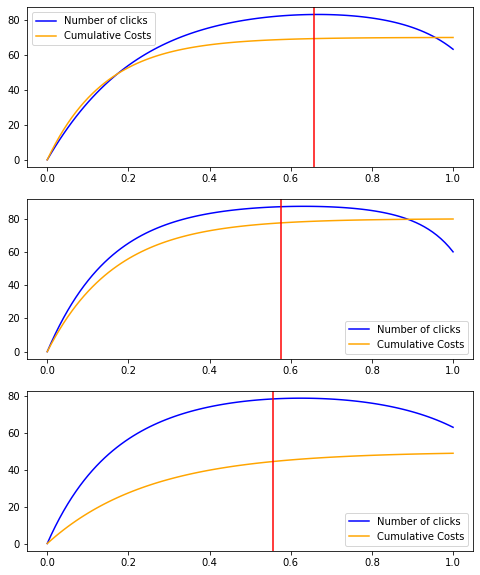

In [11]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = [3, 2.5, 3]
sigma_costs = [3, 2.5, 3]

params_clicks = [[100, 4, 3, 3],
                 [95,  6, 5, 3],
                 [100, 5, 4, 2]]
params_costs = [[70, 7],
                [80, 6],
                [50, 4]]
def clicks(x, params=[100, 4, 3, 3]):
  return params[0] * (1.0 - np.exp(-params[1]*x+params[2]*x**params[3]))

def costs(x, params=[70, 7]):
  return params[0] * (1.0 - np.exp(-params[1]*x))


opt_bid = np.zeros(3)
for i in range(0,3):
    opt_bid[i] = bids[np.argmax(opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(bids, params_clicks[i])-costs(bids, params_costs[i]))]

fig, ax = plt.subplots(3, figsize=(8,10))
for i in range(0, 3):
    ax[i].plot(bids,clicks(bids, params_clicks[i]),'blue',bids, costs(bids, params_costs[i]),'orange')
    ax[i].legend(["Number of clicks", "Cumulative Costs"])
    ax[i].axvline(opt_bid[i],c='red')
    print("Advertising (optimal bid):")
    print("idx: " + str(np.argmax(opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(bids, params_clicks[i])-costs(bids, params_costs[i]))) + "  bid: " + str(opt_bid[i]) + "  clicks-costs: " + str(clicks(opt_bid[i], params_clicks[i])-costs(opt_bid[i], params_costs[i])))

In [12]:
# Function wrapper to be able to pass to environment
def clicks1(x):
    return clicks(x, params_clicks[0])
def clicks2(x):
    return clicks(x, params_clicks[1])
def clicks3(x):
    return clicks(x, params_clicks[2])

In [13]:
# Function wrapper to be able to pass to environment
def costs1(x):
    return costs(x, params_costs[0])
def costs2(x):
    return costs(x, params_costs[1])
def costs3(x):
    return costs(x, params_costs[2])

In [14]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [48]:
def context_generation(collected_features, prices, features_to_check=[0,1], time=14): # INPUT: [x1, x2, pulled_price, reward_price] per row
    '''
    Given a record of rounds, we check if it's worth to split the analysis in different contexts based on x1 and x2.
    In our specific case (REVIEW) we consider the pricing part for evaluating the splits
        Inputs:
          collected_features(np.array(): recorded users; for each user we record its x1, x2, pulled_price and reward_price, with reward_price being the "buys or not" binary variable
                                         (it's in {0,1} => to get the mean rewards we need to mulitply by the price)
          prices (np.array): vector of prices corresponding to the arms
          features_to_check (list): features we check the split on. Defaults to [0,1], meaning that the features that we check are x0 and x1
          time (int): it's the "self.t" counter of the learner, which in this case is the number of recorded users. It could influence the confidence delta (REVIEW)

        Output:
          [bool,[a,b,c]]: "bool": tells you if there is a division ("bool" = True => there is at least a split (at the first level), look at "a" to see which variable induces the split and
                                  look at the other arguments to see if we also split at the second level)
                          "a": is the index for the variable on which a first split is made on (if a=0 we split on x0 and if a=1 we split on x1).
                          "b": if variable "a" is split, it says if the sub-leaf xa = 0 is split one more time. If it is None, the sub-leaf is not split, else it defaults to the
                               other variable (e.g. if a=1, b=0 or b=None)
                          "c": if variable "a" is split, it says if the sub-leaf xa = 1 is split one more time. If it is None, the sub-leaf is not split, else it defaults to the
                               other variable (e.g. if a=1, b=0 or b=None)

    The algorithm works as follows. Given the records of the users (NB: basically we are in a leaf):
    - check which arm is best when there is no split (group C0). This is done by computing for each arm the empirical mean of the reward (price*rate) and choosing the highest one
    - compute the lower bound of the reward for the best arm (considering the best arm a*: LB = mean(a*) - price(a*)*sqrt(-log(delta)/(2*|C0 users s.t. pulled_arm was a*|))
    - consider both "first level" splits (i.e. splits in which we divide the users of group C0 based only on one variable, e.g. split users based on x0 or based on x1; it's the first level of the tree)
    - for each "first level" split:
        - divide the users in groups C1 and C2 based on the designated variable:
        - compute the probability that each group is occuring (p_1 = |C1|/|C0|, p_2 = |C2|/|C0|)
        - compute the lower bound of these probabilities (LB_pi = p_i - sqrt(-log(delta)/(2*|C0|)))
        - check which arm is best for each group. This is done by computing for each arm the empirical mean of the reward (price*rate) for the users that have the characteristic specific to the considered
          group and choosing the highest one
        - compute the lower bound of the reward for the best arm (considering the best arm a_i* for group Ci: LB_i = mean_i(a_i*) - price(a_i*)*sqrt(-log(delta)/(2*|Ci users s.t. pulled_arm was a_i*|))
        - compute the lower bound after the split (that is LB_split = LB_p1*LB_1 + LB_p2*LB_2)
    - choose the highest LB_split between the two
    - if the chosen LB_split is higher than the LB (non split case), split the context according to the designated variables
    - create two leaves accordingly and repeat the procedure on each of them
    '''

    # confidence that we consider for the Confidence Intervals (REVIEW: does it make sense for it to be 1-1/t?)
    delta = 1-1/time

    # Compute the number of users associated with each arm (|C0 users s.t. pulled_arm was a| for each a)
    length_er_arms_0 = [len(collected_features[(collected_features[:,2]==arm)]) for arm in range(5)]
    # Compute the expected reward for each arm (price*rate)
    er_arms_0 = [np.mean(collected_features[(collected_features[:,2]==arm)], axis=0)[3] * prices[arm] if length_er_arms_0[arm]>0 else 0 for arm in range(5)]
    # Choose the best arm (that is a* with highest expected reward)
    best_er_price_index_0 = np.argmax(er_arms_0)
    # Compute the lower bound of the expected reward for the best arm (LB)
    lb_best_er_arms_0 = (max(er_arms_0) - prices[best_er_price_index_0]*np.sqrt(-np.log(delta)/(2*length_er_arms_0[best_er_price_index_0]))) if length_er_arms_0[best_er_price_index_0]>0 else 0

    #print(collected_features)

    # list in which we store the values (lower bounds) after the split
    splits = []

    # for each first level split (i.e. split C0 based on a specific feature x_k)
    for i in features_to_check: # for each feature that we must check, such feature splits group C0 in groups C1 (x_k = 0) and C2 (x_k = 1)

        # Estimate probabilities of C1 and C2 (that is p_1 = |C1|/|C0|, p_2 = |C2|/|C0| = 1 - p_1)
        prob_0 = sum(collected_features[:,i]==0) / len(collected_features)
        prob_1 = 1 - prob_0

        # Compute the lower bound of the probabilities of the two groups (LB_pi)
        lb_prob_0 = prob_0 - np.sqrt(-np.log(delta)/(2*len(collected_features)))
        lb_prob_1 = prob_1 - np.sqrt(-np.log(delta)/(2*len(collected_features)))

        # Compute the number of users associated with each arm (|Ci users s.t. pulled_arm was a| for each a)
        length_er_arms_1 = [len(collected_features[(collected_features[:,i]==0) * (collected_features[:,2]==arm)]) for arm in range(5)]
        length_er_arms_2 = [len(collected_features[(collected_features[:,i]==1) * (collected_features[:,2]==arm)]) for arm in range(5)]

        # Compute the expected reward for each arm (price*rate) for both C1 and C2
        er_arms_1 = [np.mean(collected_features[(collected_features[:,i]==0) * (collected_features[:,2]==arm)], axis=0)[3] * prices[arm] if length_er_arms_1[arm]>0 else 0  for arm in range(5)]
        er_arms_2 = [np.mean(collected_features[(collected_features[:,i]==1) * (collected_features[:,2]==arm)], axis=0)[3] * prices[arm] if length_er_arms_2[arm]>0 else 0  for arm in range(5)]

        # Choose the best arm (that is a_i* with highest expected reward)
        best_er_price_index_1 = np.argmax(er_arms_1)
        best_er_price_index_2 = np.argmax(er_arms_2)

        # Compute the lower bound of the probabilities of the two groups (LB_pi)
        lb_best_er_arms_1 = (max(er_arms_1) - prices[best_er_price_index_1]*np.sqrt(-np.log(delta)/(2*length_er_arms_1[best_er_price_index_1]))) if length_er_arms_1[best_er_price_index_1]>0 else 0
        lb_best_er_arms_2 = (max(er_arms_2) - prices[best_er_price_index_2]*np.sqrt(-np.log(delta)/(2*length_er_arms_2[best_er_price_index_2]))) if length_er_arms_2[best_er_price_index_2]>0 else 0

        # Append the value after the split
        splits.append(lb_best_er_arms_1*lb_prob_0 + lb_best_er_arms_2*lb_prob_1)

    # Select feature (x_k) with higher value after the split
    best_feature = np.argmax(splits)
    worse_feature = np.argmin(splits)
    # If the value after the split is higher than the value before the split, split C0 based on x_k into two sub-leaves
    if splits[best_feature] >= lb_best_er_arms_0:
        if len(features_to_check)-1 == 0: # If there are no other features to check, return (used for recurrent call of the function)
            return True, [features_to_check[best_feature]]
        # If there are still features to check, do the check again by passing the correct subset of records to the function s.t. we are in the specific leaf we want to consider
        # each time (recurrent call)
        check_sub0, _ = context_generation(collected_features[collected_features[:,best_feature]==0], prices, features_to_check=[worse_feature])
        check_sub1, _ = context_generation(collected_features[collected_features[:,best_feature]==1], prices, features_to_check=[worse_feature])
        return True, [features_to_check[best_feature], features_to_check[worse_feature] if check_sub0 else None, features_to_check[worse_feature] if check_sub1 else None]

    return False, []

In [16]:
# Function testing

temp=[]
for i in tqdm(range(0,100)):
  aux = []

  for i in range(1000):
      x1 = 1 if np.random.binomial(1, 1/3) > 0.5 else 0
      x2 = 1 if np.random.binomial(1, 1/4) > 0.5 else 0
      #price_buy = max(0, np.random.normal(0,10))
      pulled_price = np.random.choice([0,1,2,3,4],p=p[0]/sum(p[0]))
      aux.append([x1,x2,pulled_price, np.random.binomial(1, 0)]) if x1 == 0 else aux.append([x1,x2,pulled_price, np.random.binomial(1, 1.)])

  aux=np.array(aux)
  temp.append(context_generation(aux, prices, time = 1000)[0])
sum(temp)/len(temp)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.29it/s]


0.7

In [17]:
def create_learners(n_contexts, price, bids, sigma_clicks, sigma_costs):
  '''
  Given a number of contexts, it generates the necessary learners for each of them, that is:
    - pricing learner (Thompson Sampling)
    - advertasting learners:
      - GPTS
      - GPUCB
  and generates/re-initializes the vectors for the daily_pricing_rewards which will be needed for keeping track of the rewards during the 14 days that the contexts are active in
    -
  '''

  pricing_learners_gpts = [TS_Pricing_Learner(n_arms = len(price), prices = price) for c in range(n_contexts)]
  pricing_learners_gpucb =[TS_Pricing_Learner(n_arms = len(price), prices = price) for c in range(n_contexts)]
  gpts_learners = [GPTS_Learner(n_arms = len(bids), arms = bids, alpha_clicks = sigma_clicks, alpha_costs = sigma_costs,
                              step = 1, normalize_y = False,plot = False, step_delay = 0) for c in range(n_contexts)]
  gpucb_learners = [GPUCB_Learner(n_arms = len(bids), arms = bids, alpha_clicks = sigma_clicks, alpha_costs = sigma_costs,
                                step = 1, normalize_y = False, step_delay = 0) for c in range(n_contexts)]

  gpts_daily_pricing_rewards = [np.array([]) for c in range(n_contexts)]
  gpucb_daily_pricing_rewards = [np.array([]) for c in range(n_contexts)]

  return pricing_learners_gpts, pricing_learners_gpucb, gpts_learners, gpucb_learners, gpts_daily_pricing_rewards, gpucb_daily_pricing_rewards


def click_constant_from_context(x1, x2):
  '''
  Given the values of variables x1 and x2 (change of notation w.r.t. x0 and x1 in the context_generation) that characterize a context/leaf, it generates the vector of coefficients "k"
  that is used for generating the users belonging to that context. The possible values for x1 and x2 are:
    - 0: x_k = 0
    - 1: x_k = 1
    - 2: x_k = free
  The "k" vectors will be used for multiplying the rewards that are returned from the 3 different environments that we work with, so that the users and interactions actually respect the feature-wise
  discrimination induced by the different contexts.
  We recall that the users can be of 3 different tipes:
    - x1 = 1, x2 = free: generated by environment_1 (class 1)
    - x1 = 0, x2 = 1: generated by environment_2 (class 2)
    - x1 = 0, x2 = 0: generated by environment_3 (class 3)
  With each class having the same probability of being observed.
  At any given time, the sum of the "k" vectors of all the active contexts should be [1,1,1],
  '''

  if x1 == 0:
    if x2 == 1:
      return [0,1,0]
    elif x2 == 0:
      return [0,0,1]
    elif x2 == 2:
      return [0,1,1]
  elif x1 == 1:
    if x2 == 1 or x2 == 0:
      return [1/2,0,0]
    elif x2 == 2:
      return [1,0,0]
  elif x1 == 2:
    if x2 == 1:
      return [1/2,1,0]
    elif x2 == 0:
      return [1/2,0,1]
    elif x2 == 2:
      return [1,1,1]

# helper function for saving temporary results
def save_results(x, T):
  np.savetxt("gpts_rewards_per_experiment"+str(T)+".csv", x, delimiter=",")

# helper function for loading temporary results
def load_results(fname):
  return np.loadtxt(fname, delimiter=",")

In [18]:
# PSEUDO-CODE
# 4.2:
  # run basic algorithm for 2 weeks (Aggregate model, 1 context), for every person (n total) observe also x1,x2
    # depending on x1 and x2 we use the corresponding environment variables: click and cost fct and sigmas, price probs.
    # use same prices for all classes

  # after 2 weeks, run context-generator algorithm (n tuples: [x1,x2,buy*price]) <=> classification algorithm that maps (x1,x2)->(a,b,c,... M) classes, since we don't know the actual ones
    # For x1 -> check split condition (using lower bound on the expected rewards)
    # For x2 -> check split condition (using lower bound on the expected rewards)
    # return current best context strategy

  # for each day 14:365 run Dissagregate model:
    # We create M bidding learners and M pricing learners
    # pull M bids -> mapped into 3 bids for the observation/generation purposes
    # observe a certain amount of clicks (clicks1 [1,.], clicks2 [0,1], clicks3 [0,0]) -> mapped into clicks1, ..., clicksM by the context classification algorithm
      # for every person (n total) observe x1 and x2:
        # [1,1]->1  [0,1]->2 [1,0]->1, [0,0]->3 => clicks[1,1] = 1/2*clicks1, clicks[1,0] = 1/2*clicks1
        # [1,:]->1 [0,:]->2,3 => clicks[0,:] = clicks2 + clicks3
    # observe a certain amount of costs (costs1 [1,.], costs2 [0,1], costs3 [0,0]) -> mapped into costs1, ..., costsM by the context classification algorithm
      # same as clicks
    # update the M bidding_learners

    # for each class/context (1,...,M):
      # for each click:
        # pull a price
        # observe acquisition or not
        # update corresponding pricing_learner

    # after 2 weeks, update context-generator algorithm

  # reward: sum(rate[i]*price[i]*clicks[i] - costs[i])


In [58]:
# experiments
save_results_opt = False

# list for storing the number of contexts we have over time over all the experiments
mean_n_contexts = []
context_history = []

n_experiments = 10
T=365

# list for storing the rewards of all experiments
rewards_for_experiments = []


for e in tqdm(range(0,n_experiments)):  # cycle on experiments

  # environment setup ()
  env = Environment_Multiple_Contexts(n_arms = n_prices,
                                        probabilities = p,
                                        bids = bids,
                                        average_number_of_clicks = [clicks1, clicks2, clicks3],
                                        average_cum_daily_cost = [costs1, costs2, costs3],
                                        noise_clicks = sigma_clicks,
                                        noise_cost = sigma_costs)

  # initialize the array in which we store the information about the observed users, characterized by: [x1, x2, pulled_price, pricing_reward, pulled_bid, unitary_cost, time],
  # where "unitary_cost" refers to the cost that that single user imposed in the advertising process (obtained by dividing the total cost by the number of clicks for that users' class)
  collected_features = np.array([])
  first_user = 0 # auxiliary flag

  # create vector for storing the rewards of the whole experiment
  experiment_rewards = np.array([])
  current_context_history = []


  for t in range(0, T): # cycle on days

    # initialization at t = 0
    if t ==0:

      # one single context
      n_contexts = 1
      current_context_history.append([[2,2]])
      # get corresponding k coefficients ([1,1,1])
      k = np.zeros((1,3))
      k[0,:] = click_constant_from_context(x1=2, x2=2)

      # create the corresponding learners and initialize an empty vector for storing the pricing rewards for the days the context is active
      pricing_learners_gpts, _, gpts_learners, __, gpts_daily_pricing_rewards, ___ = create_learners(n_contexts, prices, bids, sigma_clicks[0], sigma_costs[0])
      # create and array for storing the cumulative costs of all the contexts for the days those contexts are active
      # (NB: for now, we are storing the daily collected costs as a single value summing the costs derived from all the contexts; it shouldn't be a problem)
      collected_costs = np.array([])

      # number of contexts of the experiment
      temp_n_contexts = [1]

    # each 14 days, run the context_generation algorithm
    if t%14 == 0 and t!=0:

      # helper for saving temporary results
      if save_results_opt:
        save_results(experiment_rewards, T=t)

      # append to the rewards of the experiment the recorded rewards of the last 14 days, obtained by summing the stored rewards over all the contexts each day (it's an array of size 14)
      experiment_rewards = np.append(experiment_rewards, np.sum([gpts_daily_pricing_rewards[j] for j in range(n_contexts)],axis=0)-collected_costs)

      # re-initialize the array for storing the costs for the days the context is active
      collected_costs = np.array([])

      # Generate the contexts through the context generation algorithm
      # in "split condition" we have at least a split and in "feature_tree" we have the characteristics about the generated leaves
      split_condition, feature_tree = context_generation(collected_features[:,:4], prices=prices, time=collected_features.shape[0])

      # if there is at least a split
      if split_condition:
        # consider the variable over which the first split is done (first_feature = 0 => x1;  first_feature = 1 => x2)
        first_feature = feature_tree[0]
        # there is a maximum of 4 possible contexts (initialized as non splitted case for convenience)
        contexts = [[2, 2],[2, 2],[2, 2],[2, 2]]
        for i in range(2):
          contexts[2*i][first_feature] = i
          contexts[2*i+1][first_feature] = i
          #example: there is a first split at level x1 => contexts = [[0,2],[0,2][1,2],[1,2]]

          # for the generated leaves (cycle given by "i" indexing), if there is another split, modify the contexts
          if feature_tree[i+1] is not None:
            second_feature = int(not first_feature)
            contexts[2*i][second_feature] = 0
            contexts[2*i+1][second_feature] = 1
            # example: there is a split in the leaf x1 = 0 => contexts = [[0,0],[0,1][1,2],[1,2]]
            #          moreover, if there is also a split in the lead x1 = 1 => contexts = [[0,0],[0,1],[1,0],[1,1]]

        # Remove duplicates by creating a set
        contexts = list(set(map(tuple, contexts)))
        # compute the number of new contexts
        n_contexts = len(contexts)

      else: # one single context context, x1=free, x2=free
        n_contexts = 1
        contexts=[(2,2)]
      current_context_history.append(contexts)

      ## REVIEW:
      k = np.zeros((n_contexts,3))

      # keep track of the number of active contexts
      temp_n_contexts.append(n_contexts)

      # create the necessary learners and storage vectors for each context (NB: for now we are omitting the GPUCB part of the algorithm)
      pricing_learners_gpts, _, gpts_learners, __, gpts_daily_pricing_rewards, ___ = create_learners(n_contexts, prices, bids, sigma_clicks[0], sigma_costs[0])

      # for each context identify exactly which values of x1 and x2 characterize them, in order to understand which recorded users are associated with each context
      for j in range(n_contexts):
        # identify which values of x1 and x2 characterizes it (and create a mask accordingly), in order to understand which recorded users (for which we know x1 and x2) are associated with it
        x1,x2 = contexts[j]
        mask = np.ones(len(collected_features), dtype=bool)
        if x1 == 2 and x2!=2:
          mask = (collected_features[:,1]==x2)
        elif x2 == 2 and x1 !=2:
          mask = (collected_features[:,0]==x1)
        elif x1!=2 and x2 != 2:
          mask = (collected_features[:,0]==x1) * (collected_features[:,1]==x2)

        # use such recorded users to initialize the learners of the context
        pricing_learners_gpts[j].initialize_learner(collected_features[mask,2:])
        gpts_learners[j].initialize_learner(collected_features[mask,2:], t)

        # generate the k coefficients of the context   (REVIEW: are we overwriting it for every context?)
        k[j,:] = click_constant_from_context(x1=contexts[j][0], x2=contexts[j][1])


    ## END OF CONTEXT INITIALIZATION (DONE EVERY 14 DAYS)

    ## START OF ACTUAL DAY-ITERATION

    #print('day:' + str(t))

    # initialization of temporary variable for storing the sum of daily costs of all the contexts
    total_daily_costs = 0

    total_daily_reward = 0

    # for each context
    for j in range(n_contexts):
      #print(' context: ' +str(j))
      #print(' '+str(k[j]))

      # pull a bid
      pulled_bid_ts = gpts_learners[j].pull_arm()

      # initialization of temporary variable for storing the total amount of clicks in the context
      reward_click_ts = 0

      # temporary variable for storing the daily total pricing reward coming from all the users in the context
      aux = 0

      # initialization of temporary variable for storing the total daily costs of the contexts
      reward_cost_ts = 0

      # list for temporarely storing the observed users (will be used for a shuffling so that we do not to induce an order bias in the pricing learner)
      pulled_reward_price_arr = []

      # for every environment (<-> for each one of the 3 possible classes of users)
      for env_idx in range(3):

        # if the k coefficient of the environment is 0, skip the iteration (the user class is not part of this context)
        if k[j,env_idx] == 0:
          continue

        # observe the daily clicks and costs for this class
        reward_click_ts_, reward_cost_ts_ = env.bidding_round(pulled_bid_ts, env_idx)
        # update the total daily clicks and costs of the context
        reward_click_ts += k[j,env_idx]*reward_click_ts_
        reward_cost_ts += k[j,env_idx]*reward_cost_ts_
        #print('   environment '+str(env_idx)+' clicks:' + str(reward_click_ts_))
        #print('   environment '+str(env_idx)+' costs :' + str(reward_cost_ts_))

        # for each user that clicks on the add
        for click_idx in range(reward_click_ts_):

          # pull a price and observe the corresponding reward  (NB: for now we are updating the pricing learner only at the end of the day)
          pulled_price = pricing_learners_gpts[j].pull_arm()
          reward_price = env.pricing_round(pulled_price, env_idx)
          #print(pulled_price)

          # Set x1 and x2 to the current user class
          if env_idx==0:
            if np.random.binomial(1,1/2):
              x1 = 1
              x2 = 1
            else:
              x1 = 1
              x2 = 0
          elif env_idx==1:
            x1=0
            x2=1
          elif env_idx==2:
            x1=0
            x2=0

          # store the user information in the temporary list (NB: the last term for each user is its unitary cost)
          pulled_reward_price_arr.append((pulled_price, reward_price, x1, x2, reward_cost_ts_/reward_click_ts_))

      ## END OF CYCLE ON THE ENVIRONMENTS

      # shuffle the observed users
      np.random.shuffle(pulled_reward_price_arr)

      # for each user in the shuffled users
      for arr in pulled_reward_price_arr:

        # decouple its recorded values
        pulled_price, reward_price, x1, x2, unitary_cost_ts = arr

        # update the pricing learner
        pricing_learners_gpts[j].update(pulled_price, reward_price)

        # store the record of the user ("first_user" used for indicating the initialization of the collected_features)
        if first_user == 0:
          collected_features = np.array([x1, x2, pulled_price, reward_price, pulled_bid_ts, unitary_cost_ts, t]).reshape((1,7))
          first_user += 1
        else:
          collected_features = np.append(collected_features, np.array([x1, x2, pulled_price, reward_price, pulled_bid_ts, unitary_cost_ts, t]).reshape((1,7)), axis=0)

        # update the daily total pricing reward of the context
        aux += reward_price*prices[pulled_price]
        # DEBUG
        #print(reward_price*prices[pulled_price])


      ## END OF CYCLE OVER THE OBSERVED USERS FOR THE CONTEXT

      # update the advertising learner of the context based on the total clicks
      gpts_learners[j].update(pulled_bid_ts, [reward_click_ts,reward_cost_ts])

      # DEBGUG
      #print('   actual clicks: ' +str(reward_click_ts))
      #print('   actual reward: ' + str(aux))
      #print('   actual costs: ' +str(reward_cost_ts))

      # append the daily pricing reward of the context
      gpts_daily_pricing_rewards[j] = np.append(gpts_daily_pricing_rewards[j], aux)

      # update the daily total cost over all the contexts
      total_daily_costs += reward_cost_ts

      # update the total daily pricing reward (DEBUG print purposes)
      total_daily_reward += aux

    ## END OF CYCLE ON CONTEXTS

    #collected_costs = np.append(collected_costs, reward_cost_ts)
    # REVIEW:
    collected_costs = np.append(collected_costs, total_daily_costs)
    #print('total reward: ' + str(total_daily_reward))
    #print('total costs: ' + str(total_daily_costs))

  ## END OF CYCLE ON DAYS

  # append the rewards of the last days (did not happen in the loop since the 14 days reinitialization has not been met)
  experiment_rewards = np.append(experiment_rewards, np.sum([gpts_daily_pricing_rewards[j] for j in range(n_contexts)],axis=0)-collected_costs)

  # append the reward of the experiment
  rewards_for_experiments.append(experiment_rewards)

  # append the number of contexts over time of the experiment
  mean_n_contexts.append(temp_n_contexts)

  context_history.append(current_context_history)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [30:26<00:00, 182.66s/it]


In [59]:
# print the number of contexts over time
np.mean(mean_n_contexts,axis = 0)

array([1. , 2.8, 2.3, 1.9, 1.8, 2.7, 2.8, 2.4, 2.3, 2.2, 2.6, 2.8, 2.9,
       2.3, 2.5, 2.8, 2.7, 2.5, 2.4, 2.6, 2.8, 2.7, 2.3, 2.7, 2.8, 2.4,
       2.6])

In [60]:
context_history

[[[[2, 2]],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 2), (1, 2)],
  [(0, 1), (1, 2), (0, 0)],
  [(2, 2)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 2), (1, 2)],
  [(2, 2)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(2, 2)],
  [(0, 2), (1, 2)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 2), (1, 2)],
  [(2, 2)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(2, 2)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 2), (1, 2)],
  [(0, 1), (1, 2), (0, 0)]],
 [[[2, 2]],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 2), (1, 2)],
  [(2, 2)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(2, 2)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 2), (1, 2)],
  [(2, 2)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), (1, 2), (0, 0)],
  [(0, 1), 

In [61]:
context_true = []

for i in range(len(context_history)):
  context_true.append([])
  for j in range(len(context_history[i])):
    if context_history[i][j] == [(0, 1), (1, 2), (0, 0)]:
      context_true[-1].append(1)
    else:
      context_true[-1].append(0)

print(context_true)

[[0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1], [0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1], [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1], [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1], [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1], [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]]


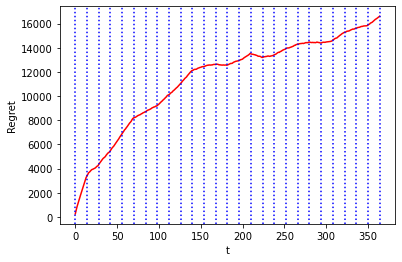

In [62]:
# optimum value computed as the sum of the optimal values for the 3 classes of users
opt = np.sum([opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(opt_bid[i], params_clicks[i]) - costs(opt_bid[i], params_costs[i]) for i in range(3)])

detections = list(range(0,T,14))
# plot the results
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - rewards_for_experiments, axis = 0)), 'r-')
for i in detections:
  plt.axvline(i,c='b',linestyle=':')

plt.show()

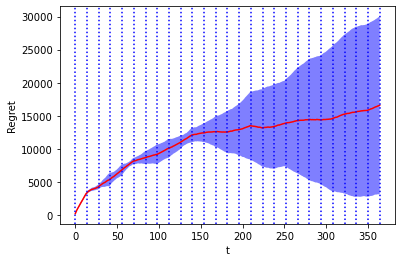

In [65]:
# optimum value computed as the sum of the optimal values for the 3 classes of users
opt = np.sum([opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(opt_bid[i], params_clicks[i]) - costs(opt_bid[i], params_costs[i]) for i in range(3)])

detections = list(range(0,T,14))
# plot the results
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - rewards_for_experiments, axis = 0)), 'r-')
for i in detections:
  plt.axvline(i,c='b',linestyle=':')

time = range(0, T)
ucb_std = np.std(np.cumsum(opt - rewards_for_experiments, axis=1), axis=0)
ucb_metric = np.mean(np.cumsum(opt - rewards_for_experiments, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')


plt.show()